# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! ls drive/'My Drive'/deep_learn/assignment1

collectSubmission.sh  knn.ipynb		    softmax.ipynb
cs231n		      README.md		    start_ipython_osx.sh
features.ipynb	      requirements.txt	    svm.ipynb
frameworkpython       setup_googlecloud.sh  two_layer_net.ipynb


In [0]:
import os
os.chdir('drive/My Drive/deep_learn/assignment1')

In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.356760
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*  
The loss that we finally get is just a way to represent the average loss acorss the entire set, now, in case of a softmax classfier, the cross-entropy loss for sample *i* is just *-1xlog(p(y_i))*, that is negative one times the probabily of the correct class. Now in case of random weights, that is, the model is not trained yet, the probabilty of correct class on average can be said as *1/(Number of classes)*, and since we have 10 equal classes in our dataset we use *-1xlog(0.1)* as our sanity check. 


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.619866 analytic: -0.619866, relative error: 6.607377e-08
numerical: -2.446811 analytic: -2.446811, relative error: 9.898234e-09
numerical: 1.204699 analytic: 1.204699, relative error: 2.065319e-08
numerical: 0.127847 analytic: 0.127847, relative error: 3.015287e-07
numerical: 1.010587 analytic: 1.010587, relative error: 3.042387e-08
numerical: 3.275427 analytic: 3.275427, relative error: 1.034468e-08
numerical: -2.654705 analytic: -2.654705, relative error: 3.760140e-09
numerical: 1.509633 analytic: 1.509633, relative error: 1.872515e-08
numerical: -1.762487 analytic: -1.762487, relative error: 2.564213e-08
numerical: 2.494759 analytic: 2.494759, relative error: 2.408003e-08
numerical: -3.149472 analytic: -3.149472, relative error: 4.112557e-09
numerical: 0.495483 analytic: 0.495483, relative error: 2.280508e-09
numerical: 1.198633 analytic: 1.198632, relative error: 7.414465e-08
numerical: -0.784701 analytic: -0.784701, relative error: 1.075857e-07
numerical: 0.336382 an

In [8]:
a = np.array([[1,2,3,4],[8,6,1,8]])
a

array([[1, 2, 3, 4],
       [8, 6, 1, 8]])

In [9]:
b = a - np.max(a, axis=1)[:,np.newaxis]
b

array([[-3, -2, -1,  0],
       [ 0, -2, -7,  0]])

In [10]:
np.sum(np.exp(b), axis=1)

array([1.55300179, 2.13624717])

In [11]:
c = np.exp(b) / np.sum(np.exp(b), axis=1)[:, np.newaxis]
c

array([[3.20586033e-02, 8.71443187e-02, 2.36882818e-01, 6.43914260e-01],
       [4.68110627e-01, 6.33518843e-02, 4.26861639e-04, 4.68110627e-01]])

In [12]:
ys = [1, 3]
-1*np.log(c[np.arange(len(c)), ys])

array([2.4401897 , 0.75905063])

In [13]:
np.mean(-1*np.log(c[np.arange(len(c)), ys]))

1.5996201635053742

In [14]:
om = np.ones(shape=a.shape)
om

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [15]:
zm = np.zeros(a.shape)
zm

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [16]:
zm[np.arange(len(zm)), ys] = 1
zm

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [25]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.356760e+00 computed in 0.229344s
vectorized loss: 2.356760e+00 computed in 0.015167s
Loss difference: 0.000000
Gradient difference: 0.000000


In [28]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for l in learning_rates:
  for r in regularization_strengths:
    clf = Softmax()
    _ = clf.train(X_train, y_train, learning_rate=l, reg=r, num_iters=1000, verbose=True)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    train_acc = np.mean((y_train == y_train))
    val_acc = np.mean((y_val == y_val_pred))
    results[(l, r)] = (train_acc, val_acc)
    if val_acc > best_val:
      best_val = val_acc
      best_softmax = clf
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 775.521898
iteration 100 / 1000: loss 284.827410
iteration 200 / 1000: loss 105.445137
iteration 300 / 1000: loss 39.961540
iteration 400 / 1000: loss 15.910267
iteration 500 / 1000: loss 7.128098
iteration 600 / 1000: loss 3.897192
iteration 700 / 1000: loss 2.838413
iteration 800 / 1000: loss 2.340966
iteration 900 / 1000: loss 2.143226
iteration 0 / 1000: loss 1553.675307
iteration 100 / 1000: loss 209.350949
iteration 200 / 1000: loss 29.837774
iteration 300 / 1000: loss 5.878692
iteration 400 / 1000: loss 2.647250
iteration 500 / 1000: loss 2.223636
iteration 600 / 1000: loss 2.156040
iteration 700 / 1000: loss 2.110971
iteration 800 / 1000: loss 2.123177
iteration 900 / 1000: loss 2.201314
iteration 0 / 1000: loss 779.732629
iteration 100 / 1000: loss 6.915861
iteration 200 / 1000: loss 2.128110
iteration 300 / 1000: loss 2.061070
iteration 400 / 1000: loss 2.117871
iteration 500 / 1000: loss 2.164434
iteration 600 / 1000: loss 2.096230
iteration 700 / 10

In [29]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: Because let's say the new data point is such that for it the score of correct class is greater than that of the all the incorrect classes by atleast the margin, in that case there will be no accumulation of loss but there will be some accumulation of loss in the softmax loss function.

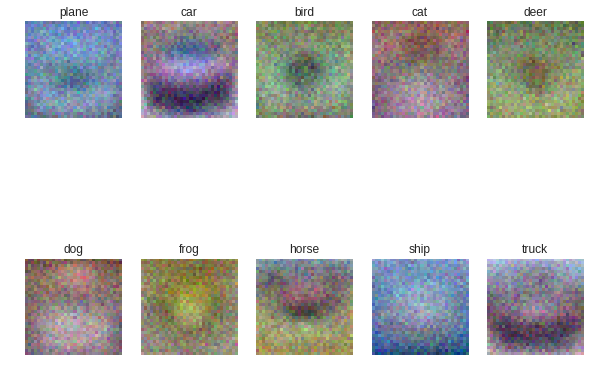

In [30]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])